# LCO

We use LCO experimental data form a paper by [Wang](https://doi.org/10.1016/j.electacta.2018.09.050).

## Data visualization

First we import the libraries that we will use throughout this example, this part is not strictly necessary to use **galpynostatic**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We load the data for the TiO$_2$ coated LCO and the $C_{rates}$ used.

In [2]:
C_rates = [0.5, 1, 2, 5, 10, 20]
dataframes = [pd.read_csv(f"data/wang/{crate}C.csv", header=None) for crate in C_rates]

we also define the equilibrium and cut-off potentials.

In [3]:
eq_pot = 3.9
vcut = 0.15

We plot the curves with the corresponding potentials as dashed horizontal lines.

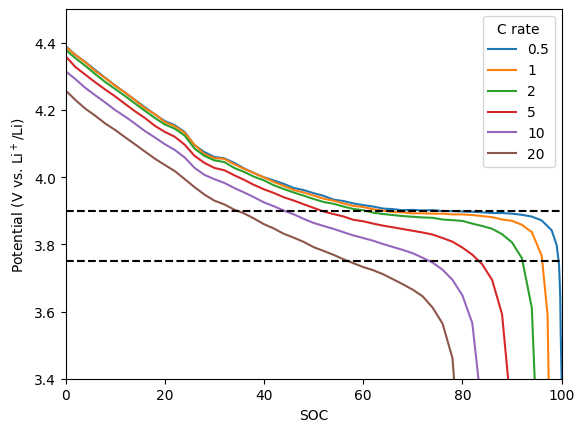

In [4]:
fig, ax = plt.subplots()

for crate, df in zip(C_rates, dataframes):
    ax.plot(df[0], df[1], label=f"{crate}")

ax.axhline(y=eq_pot, color="k", linestyle="--")
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")

ax.set_xlim((0, 100))
ax.set_ylim((3.4, 4.5))
ax.set_xlabel(r"SOC")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="C rate")
plt.show()

## Preprocessing

We can use the `preprocessing` module of `galpynostatic` to obtain the discharge capacities.

In [5]:
import galpynostatic
gdc = galpynostatic.preprocessing.GetDischargeCapacities(eq_pot)
xmaxs = gdc.fit_transform(dataframes)

In this case we divide by 100 since we have normalized the currents between 0 and 100 and we want them between 0 and 1.

In [6]:
soc = xmaxs / 100

We display the data that we are going to use to the fitting

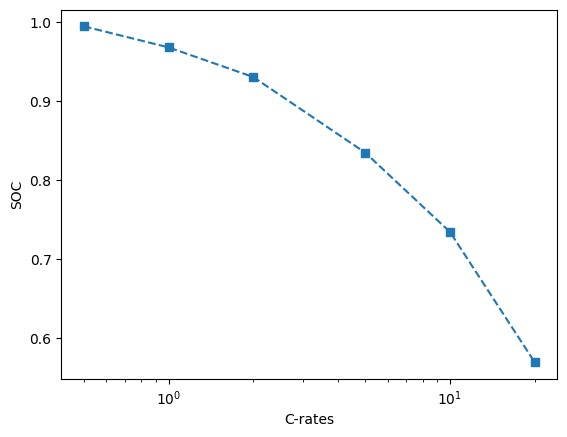

In [7]:
plt.plot(C_rates, soc, marker="s", ls="--")

plt.xlabel("C-rates")
plt.ylabel("SOC")
plt.xscale("log")
plt.show()

## Fitting

In the work it is mentioned that the particle sizes are distributed between $5-40 \mu m$, but that for measurement they take those of $20 \mu m$.

In [8]:
d = 0.002

We load the surface data for spherical geometry

In [9]:
dataset = galpynostatic.datasets.load_spherical()

And fit on it

In [10]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset, d, 3)

C_rates = np.asarray(C_rates).reshape(-1, 1)
greg.fit(C_rates, soc)

## Results

The values obtained for the diffusion coefficient and the kinetic rate constant are

In [11]:
print(f"Diffusion coefficient: {greg.dcoeff_:.3e} cm^2/s")
print(f"Kinetic rate constant: {greg.k0_:.3e} cm/s")

Diffusion coefficient: 5.337e-09 cm^2/s
Kinetic rate constant: 1.000e-05 cm/s


with a mean squared error of

In [12]:
print(f"{greg.mse_:.6f}")

0.000784


We can estimate the optimal value for the characteristic length of the nanoparticle, i.e. the size to obtain 80% of the charge in 15 minutes.

In [13]:
new_d = galpynostatic.size.predict_length(greg)
print(f"{new_d:.6f} micrometers")

28.771584 micrometers


We plot data versus predictions

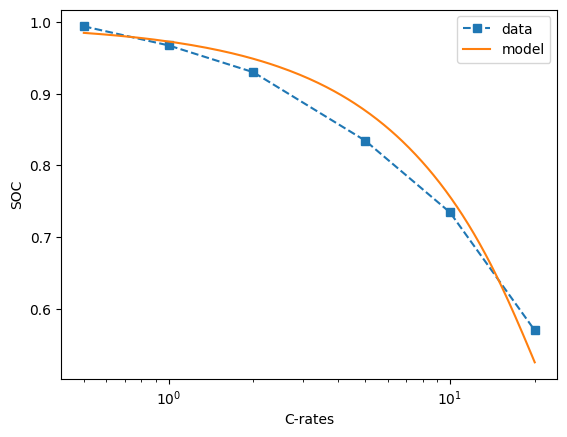

In [14]:
greg.plot.versus_data(C_rates, soc)
plt.xscale("log")
plt.legend()
plt.show()

And the data points in the surface

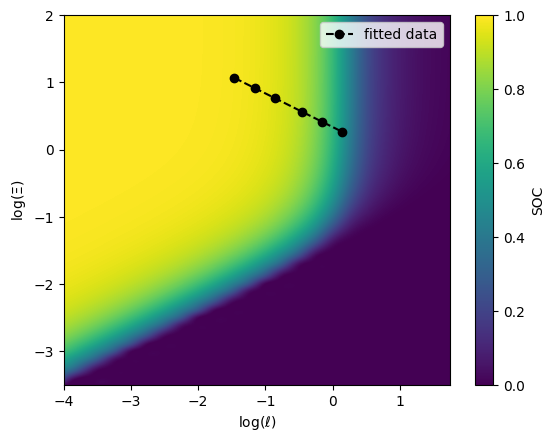

In [15]:
greg.plot.in_surface(C_rates)
plt.legend()
plt.show()